In [ ]:
%matplotlib inline 
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
# Importing time series split for cross validation 
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
file_path = '/content/drive/MyDrive/Solar energy prediction - Project/Datasets/Out/full.csv'

In [ ]:
df = pd.read_csv(file_path, parse_dates= True, index_col= 0)
df.head()

,Solaire (MW),air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2)
2017-01-01 01:00:00,0,-37.0,0.0,10180.0,4.53,0.00
2017-01-01 04:00:00,0,-40.0,0.0,10162.0,5.30,0.00
2017-01-01 07:00:00,0,-41.0,0.0,10144.0,4.92,0.00
2017-01-01 10:00:00,15,-30.0,0.0,10137.0,4.71,7.09
2017-01-01 13:00:00,22,-10.0,0.0,10115.0,4.30,84.24


In [ ]:
def error_metrics(y_pred, y_truth, model_name = None):
    """
    Printing error metrics like RMSE (root mean square error), R2 score, 
    MAE (mean absolute error). 
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    model_name: name of the model used for predictions
    
    The function will print the RMSE, R2, MAE error metrics for the model_name
    """
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)
    
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

In [ ]:
def train_test(data, split_date, scale = False, cols_to_transform=None):
    """
    
        Perform train-test split with respect to time series structure
        
        - df: dataframe with variables X_n to train on and the dependent output y which is the column 'Solaire (MW)' in this notebook
        - split_date: date fr splitting train and test dataset
        - scale: if True, then the columns in the -'cols_to_transform'- list will be scaled using StandardScaler
        
    """
    df = data.copy()
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('Solaire (MW)', axis = 1).loc[df.index <= split_date]
    y_train = df['Solaire (MW)'].loc[df.index <= split_date]
    X_test = df.drop('Solaire (MW)', axis = 1).loc[df.index > split_date]
    y_test = df['Solaire (MW)'].loc[df.index > split_date]
    
    return X_train, X_test, y_train, y_test

In [ ]:
df['year'] = df.index.year
df['month'] = df.index.month
df['hour'] = df.index.hour

In [ ]:
df.head()

,Solaire (MW),air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2),year,month,hour
2017-01-01 01:00:00,0,-37.0,0.0,10180.0,4.53,0.00,2017,1,1
2017-01-01 04:00:00,0,-40.0,0.0,10162.0,5.30,0.00,2017,1,4
2017-01-01 07:00:00,0,-41.0,0.0,10144.0,4.92,0.00,2017,1,7
2017-01-01 10:00:00,15,-30.0,0.0,10137.0,4.71,7.09,2017,1,10
2017-01-01 13:00:00,22,-10.0,0.0,10115.0,4.30,84.24,2017,1,13


# **Lasso Regression**
Fitting Lasso regression using sklearn (L1 regularization)

In [ ]:
df_lin = df.copy(deep=True)

In [ ]:
# creating categorical columns for linear regression 
cat_cols = ['year', 'month', 'hour']

for col in cat_cols:
    df_lin[col] = df_lin[col].astype('category')

In [ ]:
df_lin = pd.get_dummies(df_lin, drop_first = True)

In [ ]:
cols_to_transform = ['air_temp', 'precip_depth_per_hour', 'station_pressure_rate', 'Vitesse du vent à 100m (m/s)', 'Rayonnement solaire global (W/m2)']

In [ ]:
split_date = '2020-09-01'

In [ ]:
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test(df_lin, split_date, True, cols_to_transform)

In [ ]:
# Trying regularization: Lasso regression
from sklearn.linear_model import Lasso

# Instantiate a Lasso regressor: lasso
lasso = Lasso()

#Cross validation for time series of 5 folds
lscv = TimeSeriesSplit(n_splits=5)

#setting the grid for alpha
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)

lsgs = GridSearchCV(lasso, grid, cv=lscv, n_jobs=-1)

# Fit the regressor to the data
results = lsgs.fit(X_train_lasso, y_train_lasso)

# summarize
print('MSE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MSE: 0.782
Config: {'alpha': 0.0}


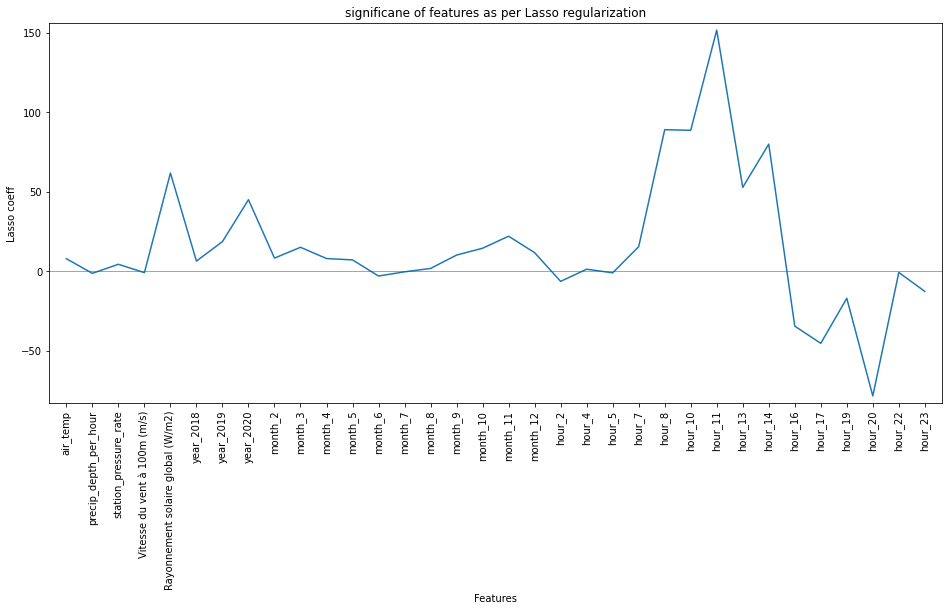

In [ ]:
# Compute and print the coefficients
lasso_best = Lasso(alpha = results.best_params_['alpha']).fit(X_train_lasso, y_train_lasso)
lasso_coef = lasso_best.coef_
# Plot the coefficients
_ = plt.figure(figsize = (16, 7))
_ = plt.plot(range(len(X_train_lasso.columns)), lasso_coef)
_ = plt.xticks(range(len(X_train_lasso.columns)), X_train_lasso.columns.values, rotation = 90)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('significane of features as per Lasso regularization')
_ = plt.ylabel('Lasso coeff')
_ = plt.xlabel('Features')

In [ ]:
pre_lasso = lasso_best.predict(X_test_lasso)

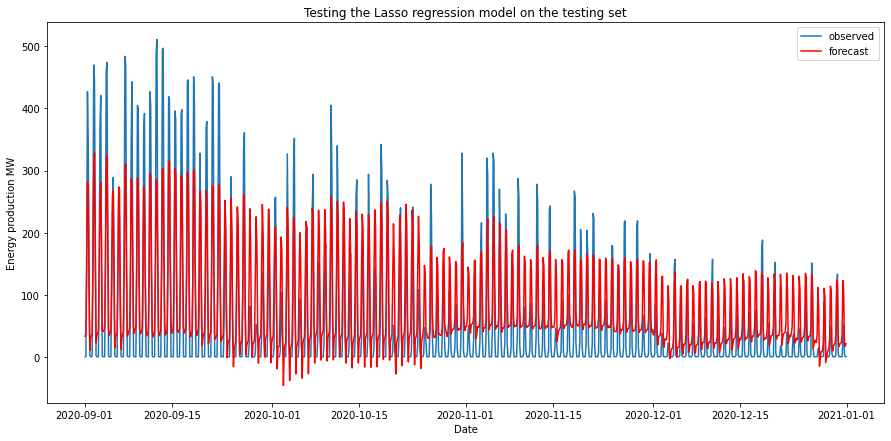

In [ ]:
plt.figure(figsize = (15,7))
_ = plt.plot(y_test_lasso.index, y_test_lasso, label='observed')

# plot your mean predictions
_ = plt.plot(y_test_lasso.index, pre_lasso, color='r', label='forecast')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the Lasso regression model on the testing set')

In [ ]:
error_metrics(lasso_best.predict(X_test_lasso), y_test_lasso, model_name = 'Lasso regression')


Error metrics for model Lasso regression
RMSE or Root mean squared error: 55.41
Variance score: 0.73
Mean Absolute Error: 44.59


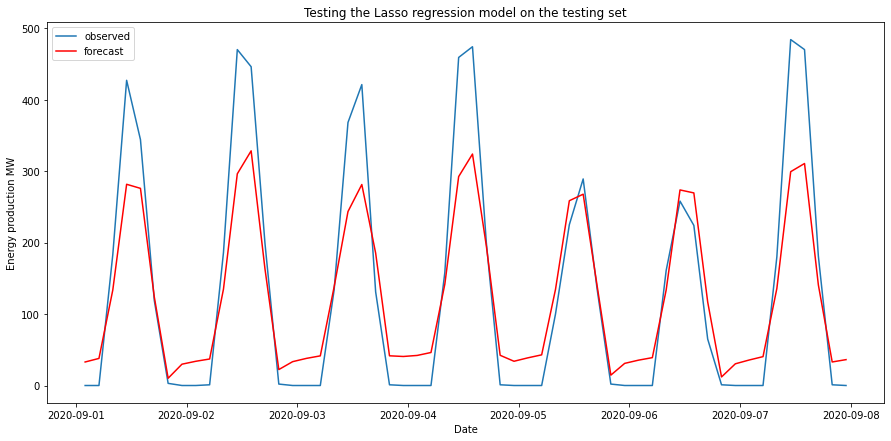

In [ ]:
#plot 1 week prediction
y_true_week = y_test_lasso[:56]
plt.figure(figsize = (15,7))
_ = plt.plot(y_true_week.index, y_true_week, label='observed')

# plot your mean predictions
_ = plt.plot(y_true_week.index, pre_lasso[:56], color='r', label='forecast')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the Lasso regression model on the testing set')

# **Reduced Feature Space**

**Trying different columns this time**
* In the above model we had used hot encoded variables like hour_1, hour_2,..., month_2, month_3,.. etc. This results in a loss of information because the model assumes that 23rd hour is far away from the 0th hour (and same for months, month_12 is far away from month_1) which is not the case because the time series is periodic and the 0th hour is as much closer to the 23rd hour as it is to the 1st hour. To avoid the loss of information and to lower the number of predictor variables we'll try some feature engineering on the X space.
* We'll also create a season column to capture the months feature. 



In [ ]:
# Dividing the hours into 4 groups-> night, morning, afternoon, evening
hour_dict = {'morning': list(np.arange(7,13)),'afternoon': list(np.arange(13,16)), 'evening': list(np.arange(16,22)),
            'night': [22, 23, 0, 1, 2, 3, 4, 5, 6]}
#Dividing the months into 4 groups-> spring, summer, autumn, winter
month_dict = {'spring': list(np.arange(3,6)),'summer': list(np.arange(6,9)), 'autumn': list(np.arange(9,12)),
            'winter': [12, 1, 2]}

In [ ]:
def time_of_day(x):
    if x in hour_dict['morning']:
        return 'morning'
    elif x in hour_dict['afternoon']:
        return 'afternoon'
    elif x in hour_dict['evening']:
        return 'evening'
    else:
        return 'night'

def season(x):
    if x in month_dict['spring']:
        return 'spring'
    elif x in month_dict['summer']:
        return 'summer'
    elif x in month_dict['autumn']:
        return 'autumn'
    else:
        return 'winter'

In [ ]:
df['time_of_day']= df['hour'].apply(time_of_day)
df['season'] = df['month'].apply(season)

In [ ]:
df.head()

,Solaire (MW),air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2),year,month,hour,time_of_day,season
2017-01-01 01:00:00,0,-37.0,0.0,10180.0,4.53,0.00,2017,1,1,night,winter
2017-01-01 04:00:00,0,-40.0,0.0,10162.0,5.30,0.00,2017,1,4,night,winter
2017-01-01 07:00:00,0,-41.0,0.0,10144.0,4.92,0.00,2017,1,7,morning,winter
2017-01-01 10:00:00,15,-30.0,0.0,10137.0,4.71,7.09,2017,1,10,morning,winter
2017-01-01 13:00:00,22,-10.0,0.0,10115.0,4.30,84.24,2017,1,13,afternoon,winter


In [ ]:
# creating categorical columns for linear regression 
cat_cols1 = ['month', 'hour', 'season', 'time_of_day']
#not including year above to capture the increasing energy trend over increasing value of years
for col in cat_cols1:
    df[col] = df[col].astype('category')

In [ ]:
df_lin2 = df.drop(columns=['hour', 'month'])
df_lin2 = pd.get_dummies(df_lin2, drop_first=True)
df_lin2.head()

,Solaire (MW),air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2),year,time_of_day_evening,time_of_day_morning,time_of_day_night,season_spring,season_summer,season_winter
2017-01-01 01:00:00,0,-37.0,0.0,10180.0,4.53,0.00,2017,0,0,1,0,0,1
2017-01-01 04:00:00,0,-40.0,0.0,10162.0,5.30,0.00,2017,0,0,1,0,0,1
2017-01-01 07:00:00,0,-41.0,0.0,10144.0,4.92,0.00,2017,0,1,0,0,0,1
2017-01-01 10:00:00,15,-30.0,0.0,10137.0,4.71,7.09,2017,0,1,0,0,0,1
2017-01-01 13:00:00,22,-10.0,0.0,10115.0,4.30,84.24,2017,0,0,0,0,0,1


In [ ]:
cols_to_transform2 = cols_to_transform + ['year']
X_train, X_test, y_train, y_test = train_test(df_lin2, split_date, True, cols_to_transform2)

In [ ]:
X_test.head()

,air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2),year,time_of_day_evening,time_of_day_morning,time_of_day_night,season_spring,season_summer,season_winter
2020-09-01 02:00:00,-0.067504,-0.116403,0.339533,-0.192307,-0.709582,1.340272,0,0,1,0,0,0
2020-09-01 05:00:00,-0.178748,-0.116403,0.318158,-1.170397,-0.711774,1.340272,0,0,1,0,0,0
2020-09-01 08:00:00,0.280135,-0.116403,0.328845,-1.060281,-0.676910,1.340272,0,1,0,0,0,0
2020-09-01 11:00:00,0.669490,-0.116403,0.254033,-0.917778,0.659863,1.340272,0,1,0,0,0,0
2020-09-01 14:00:00,1.170089,-0.116403,0.115096,-1.086191,1.668867,1.340272,0,0,0,0,0,0


Retry Lasso Regression on the reduced feature space

In [ ]:
lasso = Lasso()

#Cross validation for time series of 5 folds
lscv = TimeSeriesSplit(n_splits=5)

#setting the grid for alpha
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)

lsgs = GridSearchCV(lasso, grid, cv=lscv, n_jobs=-1)

# Fit the regressor to the data
results_reduced = lsgs.fit(X_train, y_train)

# summarize
print('MSE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MSE: 0.723
Config: {'alpha': 0.01}


In [ ]:
# Compute and print the coefficients
lasso_best2 = Lasso(alpha = results_reduced.best_params_['alpha']).fit(X_train, y_train)
lasso_coef2 = lasso_best2.coef_
pre_lasso2 = lasso_best2.predict(X_test)

In [ ]:
error_metrics(lasso_best2.predict(X_test), y_test, model_name = 'Lasso regression on reduced feature space')


Error metrics for model Lasso regression on reduced feature space
RMSE or Root mean squared error: 60.27
Variance score: 0.68
Mean Absolute Error: 44.20


Result is not really better here

# **Random Forest Regression**

In [ ]:
# Tuning Random forest
# n_estimators = number of trees in the forest
# max_features = max number of features considered for splitting a node

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(10, 200, 10, endpoint=True)]
max_features = ['auto', 'sqrt']
max_depth = list(range(1,6))
# Create the random grid
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth':max_depth}
print(random_grid)

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 3, 4, 5]}


In [ ]:
# First create the base model to tune
rf = RandomForestRegressor()

# Creating a time series split
tscv = TimeSeriesSplit(n_splits=5)

# Random search of parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = tscv, verbose=2, random_state = 42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_
#rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.4s finished


{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 73}

In [ ]:
rf_random.score(X_train, y_train)

0.8861595599057711

In [ ]:
rf_random.score(X_test,y_test)

0.8488997934339602

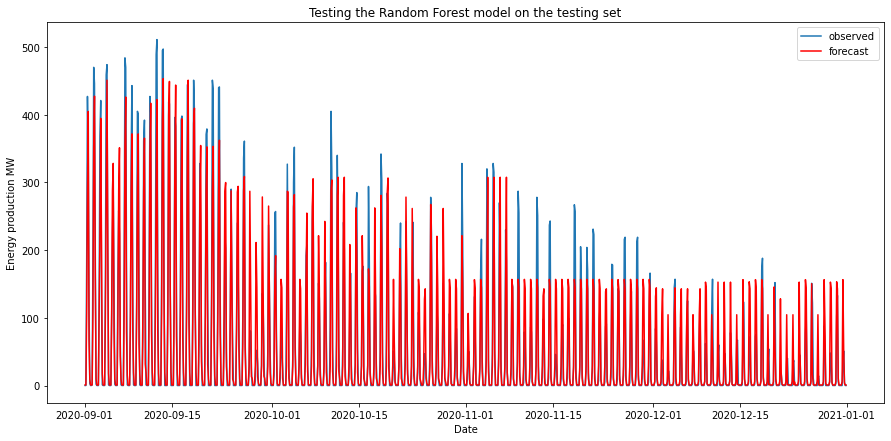

In [ ]:
# Plotting the observed test energy and predicted energy data on the same graph as line plots
plt.figure(figsize = (15,7))
_ = plt.plot(y_test.index, y_test, label='observed')

# plot predictions
_ = plt.plot(y_test.index, rf_random.predict(X_test), color='r', label='forecast')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the Random Forest model on the testing set')

In [ ]:
error_metrics(rf_random.predict(X_test), y_test, model_name = 'Tuned Random forest with reduced hour space')


Error metrics for model Tuned Random forest with reduced hour space
RMSE or Root mean squared error: 41.24
Variance score: 0.85
Mean Absolute Error: 21.63


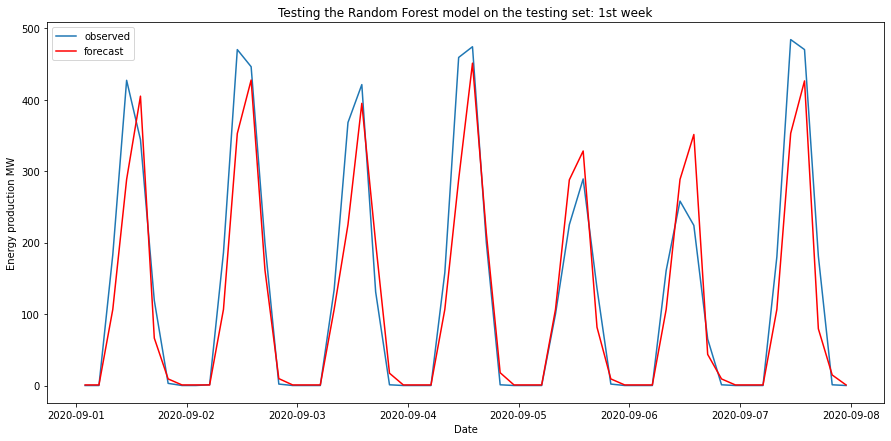

In [ ]:
#plot 1 week prediction
y_true_week = y_test[:56]
plt.figure(figsize = (15,7))
_ = plt.plot(y_true_week.index, y_true_week, label='observed')

# plot your mean predictions
_ = plt.plot(y_true_week.index, rf_random.predict(X_test)[:56], color='r', label='forecast')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the Random Forest model on the testing set: 1st week')

In [ ]:
error_metrics(rf_random.predict(X_test)[:56], y_test[:56], model_name = 'Tuned Random forest with reduced hour space: 1 week')


Error metrics for model Tuned Random forest with reduced hour space: 1 week
RMSE or Root mean squared error: 56.27
Variance score: 0.88
Mean Absolute Error: 34.71


# **Elastic Net Regression**

In [ ]:
# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [ ]:
import warnings  
warnings.filterwarnings('ignore')

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
alpha_space = np.logspace(-2, 0, 30)
param_grid = {'l1_ratio': l1_space, 'alpha': alpha_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

# Setup the GridSearchCV object: gm_cv trying 5 fold cross validation 
gm_cv = GridSearchCV(elastic_net, param_grid, cv = tscv)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

print("Tuned ElasticNet parameters: {}".format(gm_cv.best_params_))

Tuned ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 1.0}


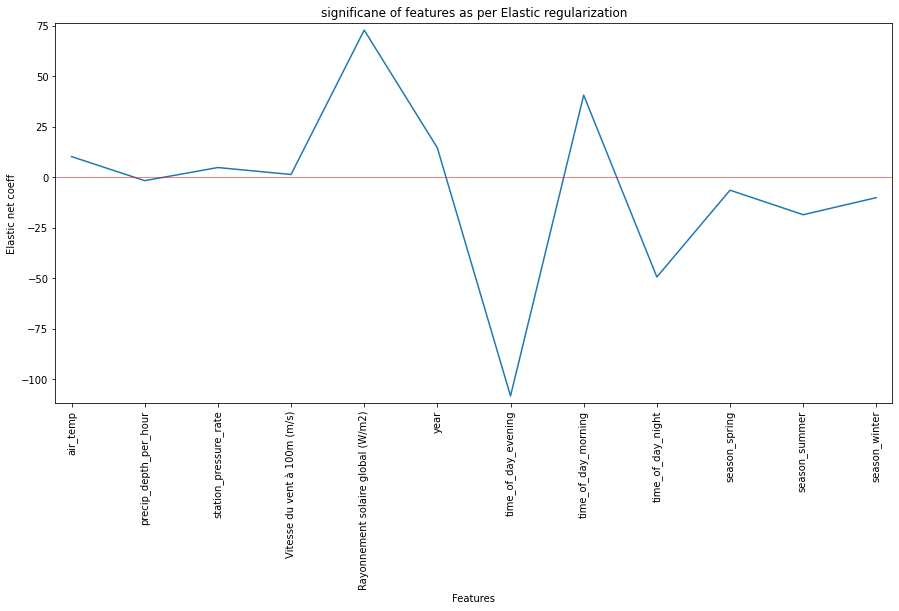

In [ ]:
en_best = ElasticNet(l1_ratio = gm_cv.best_params_['l1_ratio'], alpha=gm_cv.best_params_['alpha']) 
en_best.fit(X_train, y_train)

# Plot the coefficients
_ = plt.figure(figsize = (15, 7))
_ = plt.plot(range(len(X_train.columns)), en_best.coef_)
_ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('significane of features as per Elastic regularization')
_ = plt.ylabel('Elastic net coeff')
_ = plt.xlabel('Features')

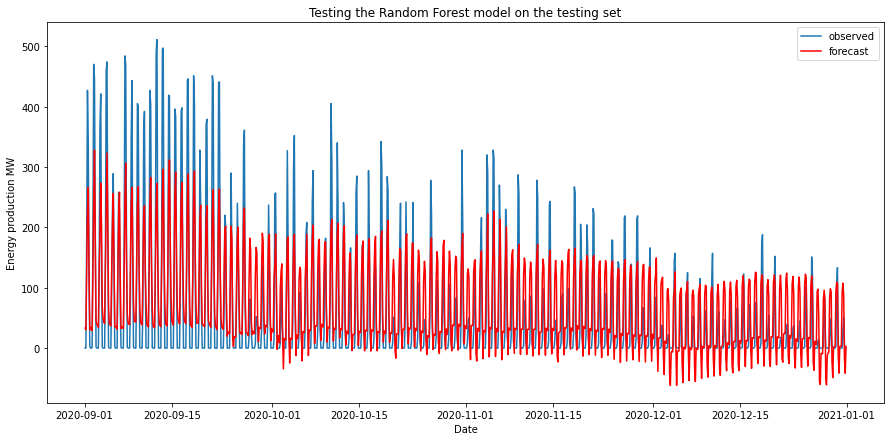

In [ ]:
# Plotting the observed test energy and predicted energy data on the same graph as line plots
plt.figure(figsize = (15,7))
_ = plt.plot(y_test.index, y_test, label='observed')

# plot predictions
_ = plt.plot(y_test.index, en_best.predict(X_test), color='r', label='forecast')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the Random Forest model on the testing set')

In [ ]:
error_metrics(en_best.predict(X_test), y_test, model_name = 'Tuned elastic net regression with reduced hour space')


Error metrics for model Tuned elastic net regression with reduced hour space
RMSE or Root mean squared error: 60.27
Variance score: 0.68
Mean Absolute Error: 44.20


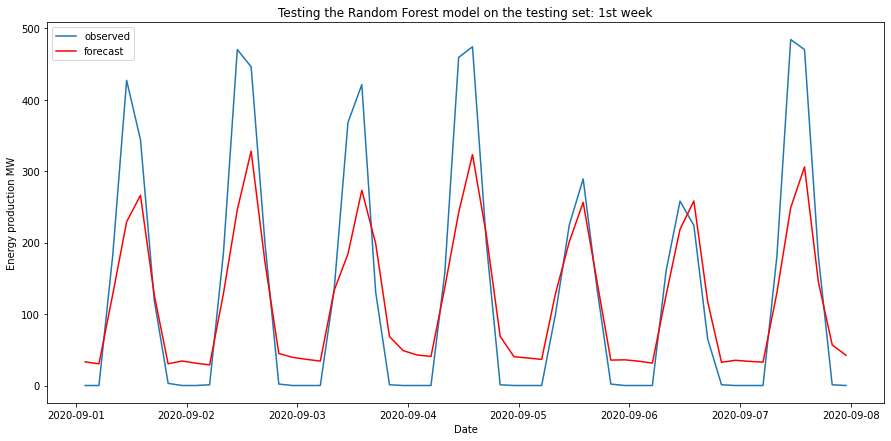

In [ ]:
#plot 1 week prediction
y_true_week = y_test[:56]
plt.figure(figsize = (15,7))
_ = plt.plot(y_true_week.index, y_true_week, label='observed')

# plot your mean predictions
_ = plt.plot(y_true_week.index, en_best.predict(X_test)[:56], color='r', label='forecast')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the Random Forest model on the testing set: 1st week')

In [ ]:
error_metrics(en_best.predict(X_test)[:56], y_test[:56], model_name = 'Tuned elastic net regression with reduced hour space: 1 week')


Error metrics for model Tuned elastic net regression with reduced hour space: 1 week
RMSE or Root mean squared error: 83.18
Variance score: 0.74
Mean Absolute Error: 60.55


Result is not as good as Random Forest Regression

# **XGBoost**

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [ ]:
xgb_reg = xgb.XGBRegressor()

In [ ]:
random_grid

{'max_depth': [1, 2, 3, 4, 5],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}

In [ ]:
param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}

tscv = TimeSeriesSplit(n_splits=3)
xgbtunedreg = RandomizedSearchCV(xgb_reg, 
                                 param_distributions=param_grid,
                                 n_iter=20, 
                                 scoring='neg_mean_squared_error', 
                                 n_jobs=-1, 
                                 cv=tscv,
                                 verbose=3,
                                 random_state=42)
xgbtunedreg.fit(X_train, y_train)
best_score = xgbtunedreg.best_score_
best_params = xgbtunedreg.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.8s finished


[18:59:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: -2127.431020900789
Best params: 
colsample_bylevel: 0.6
colsample_bytree: 0.9
gamma: 0.5
learning_rate: 0.3
max_depth: 6
min_child_weight: 7.0
n_estimators: 115
subsample: 0.9


In [ ]:
pred_xbg = xgbtunedreg.predict(X_test)

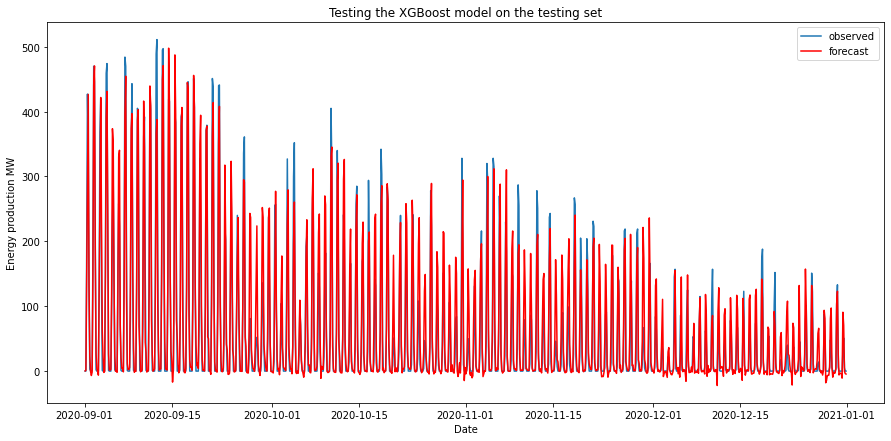

In [ ]:
# Plotting the observed test energy and predicted energy data on the same graph as line plots
plt.figure(figsize = (15,7))
_ = plt.plot(y_test.index, y_test, label='observed')

# plot predictions
_ = plt.plot(y_test.index, pred_xbg, color='r', label='forecast')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the XGBoost model on the testing set')

In [ ]:
error_metrics(pred_xbg, y_test, model_name = 'Tuned XGBoost')


Error metrics for model Tuned XGBoost
RMSE or Root mean squared error: 38.96
Variance score: 0.87
Mean Absolute Error: 22.30


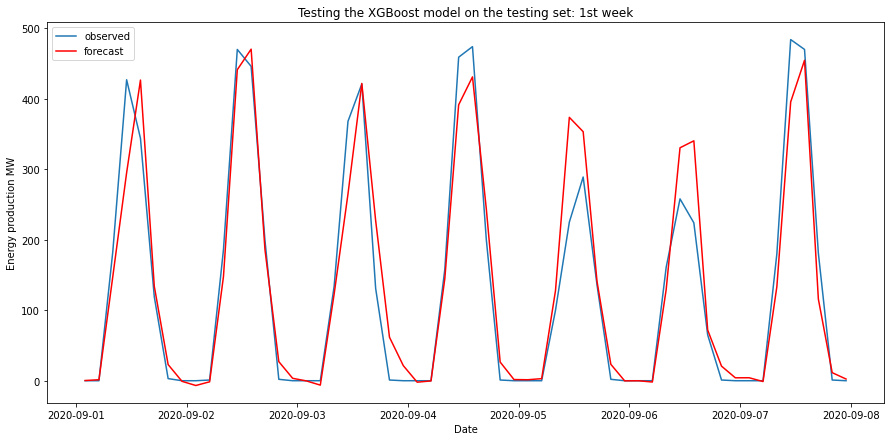

In [ ]:
#plot 1 week prediction
y_true_week = y_test[:56]
plt.figure(figsize = (15,7))
_ = plt.plot(y_true_week.index, y_true_week, label='observed')

# plot your mean predictions
_ = plt.plot(y_true_week.index, pred_xbg[:56], color='r', label='forecast')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the XGBoost model on the testing set: 1st week')

In [ ]:
error_metrics(pred_xbg[:56], y_test[:56], model_name = 'Tuned elastic net regression with reduced hour space: 1 week')


Error metrics for model Tuned elastic net regression with reduced hour space: 1 week
RMSE or Root mean squared error: 47.34
Variance score: 0.92
Mean Absolute Error: 30.08
